In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

import pickle
import os
import random

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [143]:
!! unzip data.zip

['Archive:  data.zip',
 'replace data/nice_embed_tsne.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL',
 '(EOF or read error, treating as "[N]one" ...)']

In [144]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [145]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [146]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [2]:
def flatten(x):
    return [item for sublist in x for item in sublist]

def make_dictionary(all_codones):
    flat_codones = flatten(all_codones)
    unique_codones = set(flat_codones)
    dictionary = {cod: i for i, cod in enumerate(unique_codones)}
    return dictionary

In [148]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

dictionary = make_dictionary(all_codones)

reading data/all_codones.pickle


In [149]:
def generate_sample(index_words_list, context_window_size, neg_size):
    """ Form training pairs according to the skip-gram model. """
    
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                yield center, target, np.random.randint(0, len(dictionary), neg_size)
                
            # get a random target after the center word
            for target in index_words[index + 1: index + context + 1]:
                yield center, target, np.random.randint(0, len(dictionary), neg_size)


def get_batch(iterator, batch_size, neg_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        neg_batch = np.zeros((batch_size, neg_size), dtype=np.int32)
        for index in range(batch_size):
            center_batch[index], target_batch[index], neg_batch[index] = next(iterator)
        yield center_batch, target_batch, neg_batch

def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]

def process_data(all_codones, dictionary, batch_size, skip_window, neg_size):
    print(1)
    cod_dicts = [cod_to_dict(cod, dictionary) for cod in all_codones]
    print(2)
    single_gen = generate_sample(cod_dicts, context_window_size=skip_window, neg_size=neg_size)
    print(3)
    batch_gen = get_batch(single_gen, batch_size=batch_size, neg_size=neg_size)
    print(4)
    return batch_gen

In [150]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

VOCAB_SIZE = 9424
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 5  # Number of negative examples to sample.
LEARNING_RATE = .2
NUM_TRAIN_STEPS = 100000
SKIP_STEP = 4000

batch_gen = process_data(all_codones, dictionary, BATCH_SIZE, SKIP_WINDOW, NUM_SAMPLED)

1
2
3
4


In [101]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [129]:
class skipgram(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super(skipgram, self).__init__()
        self.u_embeddings = nn.Embedding(vocab_size, embedding_dim, sparse=True)   
        self.v_embeddings = nn.Embedding(vocab_size, embedding_dim, sparse=True) 
        self.embedding_dim = embedding_dim
        self.init_emb()
    
    def init_emb(self):
        init_range = 1.0#0.5 / self.embedding_dim
        self.u_embeddings.weight.data.uniform_(-init_range, init_range)
        self.v_embeddings.weight.data.uniform_(-0, 0)
    
    def forward(self, u_pos, v_pos, v_neg, batch_size):
        
        # pos
        embed_u = self.u_embeddings(u_pos)
        embed_v = self.v_embeddings(v_pos).squeeze()
        
        score  = torch.mul(embed_u, embed_v)
        score = torch.sum(score, dim=1)
        log_target = F.logsigmoid(score).squeeze()

        # neg
        neg_embed_v = self.v_embeddings(v_neg)
        neg_score = torch.bmm(neg_embed_v, embed_u.unsqueeze(2)).squeeze()
        sum_log_sampled = torch.sum(F.logsigmoid(-1*neg_score), dim=1)

        loss = log_target + sum_log_sampled

        return -loss.mean()
    
    def input_embeddings(self):
        return self.u_embeddings.weight.data.cpu().numpy()

In [140]:
        
def train(epoch_num, learning_rate, batch_size):
    total_loss = 0.0
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    for i in range(epoch_num):
        centers, targets, negs = next(batch_gen)  
        centers, targets, negs = torch.LongTensor(centers), torch.LongTensor(targets), torch.LongTensor(negs)

        loss = model(centers, targets, negs, batch_size)
        optimizer.zero_grad()
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        if i % 500 == 0:
            print("Step {} AvLoss {}".format(i, loss.item()))
            total_loss = 0

    # return final embedding 
    return model.input_embeddings()
        

In [153]:
model = skipgram(VOCAB_SIZE, EMBED_SIZE)

final_embed_matrix =  train(NUM_TRAIN_STEPS, LEARNING_RATE, BATCH_SIZE)

here
Step 0 AvLoss 4.1588826179504395
Step 500 AvLoss 4.15796422958374
Step 1000 AvLoss 4.166714191436768
Step 1500 AvLoss 4.183692932128906
Step 2000 AvLoss 3.8149445056915283
Step 2500 AvLoss 3.5220212936401367
Step 3000 AvLoss 2.6650516986846924
Step 3500 AvLoss 3.046656847000122
Step 4000 AvLoss 3.3335893154144287
Step 4500 AvLoss 1.3488963842391968
Step 5000 AvLoss 3.3559114933013916
Step 5500 AvLoss 2.249934434890747
Step 6000 AvLoss 1.7997441291809082
Step 6500 AvLoss 1.806316614151001
Step 7000 AvLoss 2.8934311866760254
Step 7500 AvLoss 1.3416743278503418
Step 8000 AvLoss 3.241140127182007
Step 8500 AvLoss 3.850248336791992
Step 9000 AvLoss 2.9606263637542725
Step 9500 AvLoss 2.533294677734375
Step 10000 AvLoss 2.684248208999634
Step 10500 AvLoss 2.271883487701416
Step 11000 AvLoss 2.352200984954834
Step 11500 AvLoss 2.031790256500244
Step 12000 AvLoss 2.1420605182647705
Step 12500 AvLoss 1.837231159210205
Step 13000 AvLoss 1.926338791847229
Step 13500 AvLoss 1.9550585746765137

In [154]:
tsne = TSNE(n_components=2, random_state=42)
XX = tsne.fit_transform(final_embed_matrix)

In [155]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

,x0,x1,codone
0,-3.136168,0.804672,UEL
1,-1.375224,-3.427207,YYM
2,1.957523,0.122836,LPF
3,-4.574780,1.105947,XTX
4,-1.955324,-2.944622,NCA


In [156]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

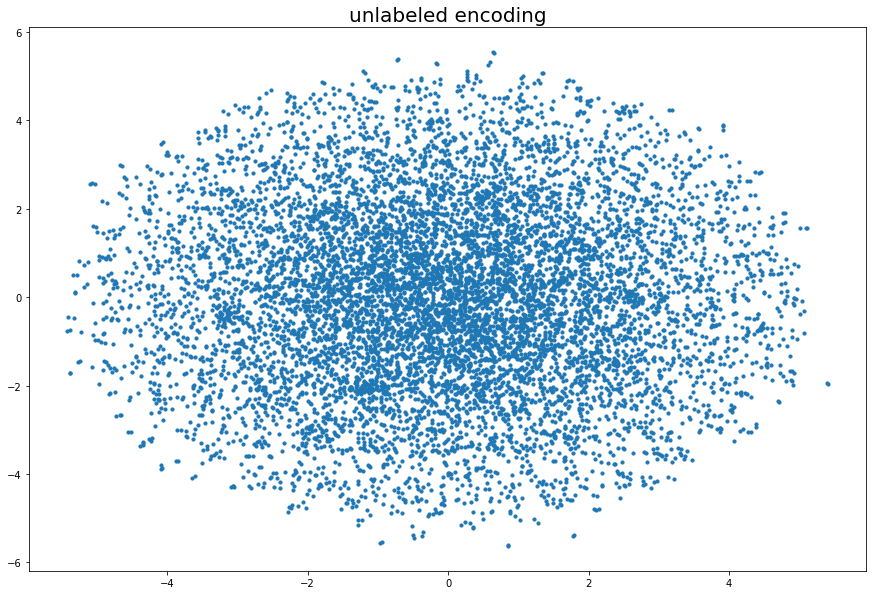

In [157]:
plot_tsne_df(tsne_df)

In [158]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [160]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [161]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

saving data/all_acid_dicts.pickle


In [162]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume
0,UEL,0.150000,130.769833,20.500000,152.550000
1,YYM,-0.233333,152.514233,22.666667,183.366667
2,LPF,1.666667,119.148900,20.666667,156.433333
3,XTX,-0.700000,101.103900,17.000000,116.100000
4,NCA,0.266667,96.107800,14.666667,103.733333


In [163]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume,x0,x1
0,UEL,0.150000,130.769833,20.500000,152.550000,-3.136168,0.804672
1,YYM,-0.233333,152.514233,22.666667,183.366667,-1.375224,-3.427207
2,LPF,1.666667,119.148900,20.666667,156.433333,1.957523,0.122836
3,XTX,-0.700000,101.103900,17.000000,116.100000,-4.574780,1.105947
4,NCA,0.266667,96.107800,14.666667,103.733333,-1.955324,-2.944622


In [164]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

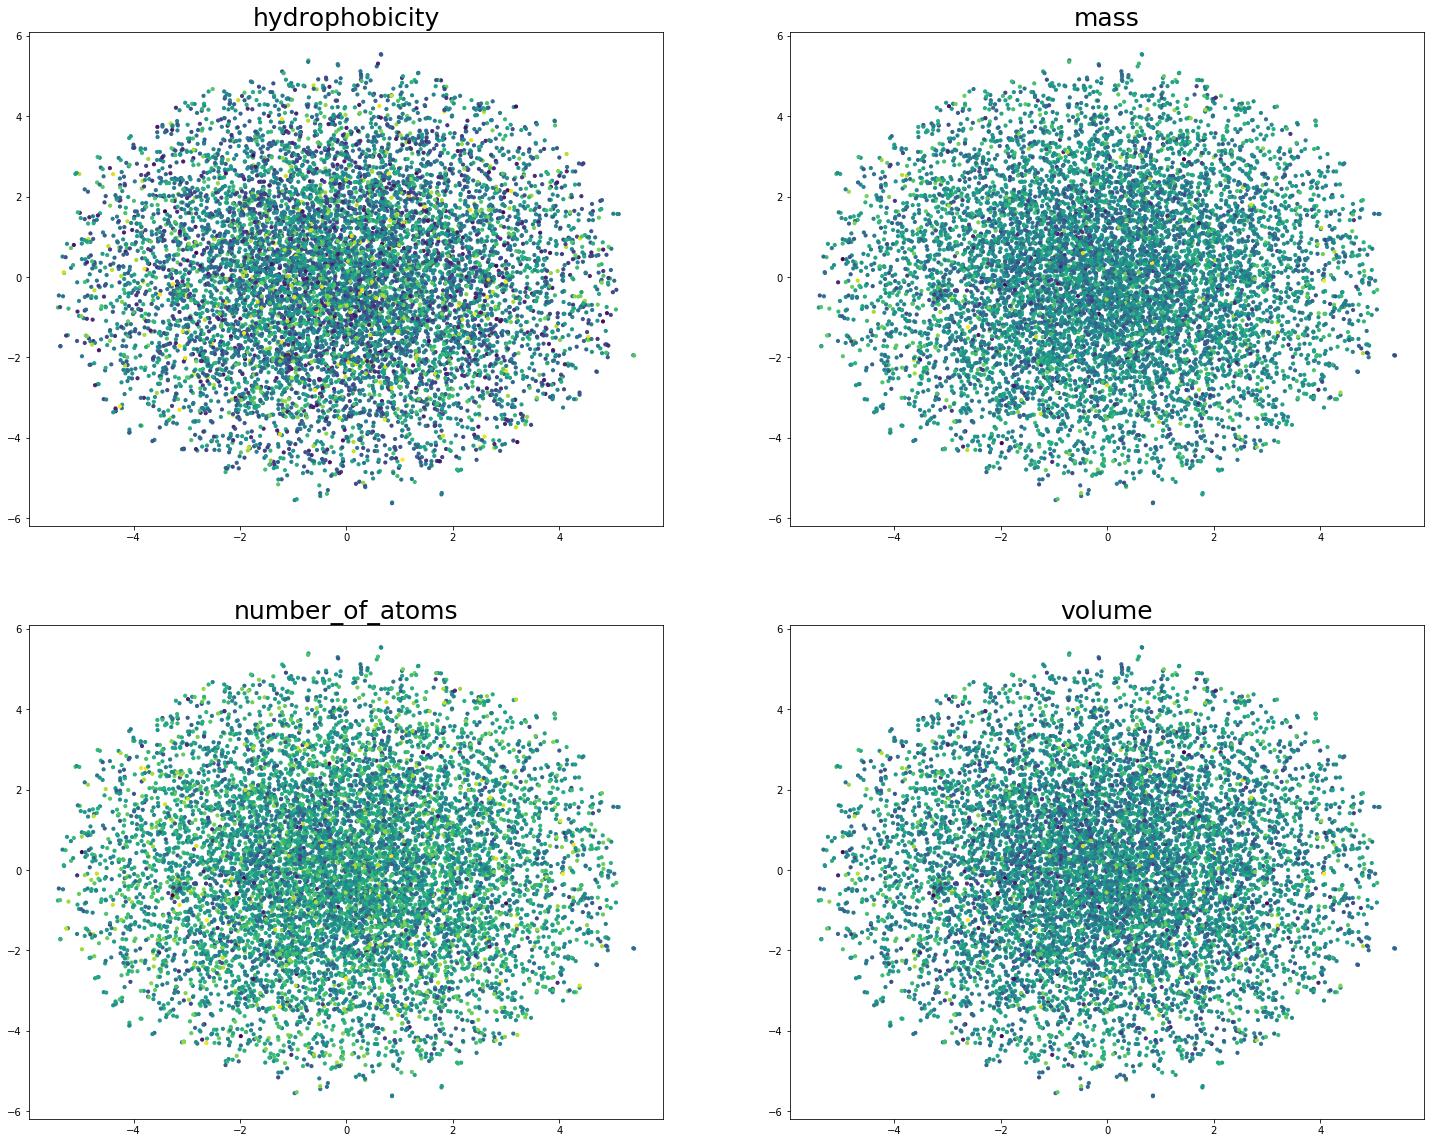

In [165]:
plot_embedding_properties(final_df)